# Implementation on Python

First, we will import some necessary libraries for our code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm, beta

The next step is to extract all points (or $xyz$-coordinates) inside a grain by the grain's ID. The function is provided by Ben Nguyen.

In [2]:
# Get a grain by grain ID
RVE = {}
file_open = open("text1.txt", 'r')
for line in file_open:
    line_split = line.split(" ")
    line_split.pop()
    grainID = int(line_split[-1])
    if grainID in RVE:
        RVE[grainID].append([int(line_split[3]), int(line_split[4]), int(line_split[5])])
    else:
        RVE[grainID] = [[int(line_split[3]), int(line_split[4]), int(line_split[5])]]

Here, each voxel is only given as coordinates, so we will create another data for storing the $8$ vertices of each voxel for fitting. The reason for this is that if the method consider each voxel as a point, then in the case that the grain is a single $1\times1\times1$ voxel would lead to the ellipsoid collapses into a single point. Considering a voxel as a cube with $8$ vertices and fit the ellipsoid to the vertices solves the problem. 

In [3]:
vertices = {}
for i in RVE:
    indices = np.array(RVE[i])
    x = indices
    x = np.append(x, indices - [1, 0, 0], axis=0)
    x = np.append(x, indices - [0, 1, 0], axis=0)
    x = np.append(x, indices - [0, 0, 1], axis=0)
    x = np.append(x, indices - [1, 1, 0], axis=0)
    x = np.append(x, indices - [1, 0, 1], axis=0)
    x = np.append(x, indices - [0, 1, 1], axis=0)
    x = np.append(x, indices - [1, 1, 1], axis=0)
    vertices[i] = np.unique(x, axis=0)

Now, we pick a random grain ID as an example for our function.

In [4]:
A = 579

The main part of our implementation is the function `fitEllipsoid` below, which is based on the theory discussed above. This function will take an array of $xyz$-coordinates as input, and return outputs as all necessary statistics for us to define our ellipsoid.

In [5]:
# Set RVE dimension and resolution
dim = 100
res = 5

# Fit an ellipsoid to the grain
def fitEllipsoid(i):
    """Returns the best-fitted ellipsoid to a 3D region defined by a set of points on xyz-coordinate.
       Input:
        i   : our grain ID
       Output
        mu_x, mu_y, mu_z: the center of our ellipsoid
        Sigma           : a matrix such that inv(Sigma) define our quadric surface
        L               : an array containing the length of the semi-axes of our ellipsoid
        R               : the rotational matrix
    """
    
    # Get the grain's vertices and volume
    A = np.transpose(vertices[i])
    n = np.shape(RVE[i])[0]
    # Calculate the center of our ellipsoid
    mu_x = np.average(A[0])
    mu_y = np.average(A[1])
    mu_z = np.average(A[2])
    # Define our quadric surface, which is equal to the dispersion matrix of our data
    Sigma = [[np.cov(A[0],A[0])[0][1], np.cov(A[0],A[1])[0][1], np.cov(A[0],A[2])[0][1]],
             [np.cov(A[1],A[0])[0][1], np.cov(A[1],A[1])[0][1], np.cov(A[1],A[2])[0][1]],
             [np.cov(A[2],A[0])[0][1], np.cov(A[2],A[1])[0][1], np.cov(A[2],A[2])[0][1]]]
    # Extract the axes and the rotation matrix
    L, R = np.linalg.eig(Sigma)
    # Scale the axes by volume
    scaling = np.cbrt(3*n/(4*np.pi*np.sqrt(np.prod(L))))
    L = np.sqrt(L) * scaling
    # Correct the rotation matrix
    R = np.transpose(R)
    
    # Return the results
    return mu_x, mu_y, mu_z, Sigma, L, R

Now that our function `fitEllipsoid` is implemented, we can fit an ellipsoid to our chosen grain.

In [6]:
mu_x, mu_y, mu_z, Sigma, L, R = fitEllipsoid(A)

From the calculated rotation matrix $R$, we can extract Euler angles $\alpha$, $\beta$, $\gamma$ using the discussed scheme.

In [7]:
# Euler angles
a = np.arctan2(R[2][1], R[2][2])
b = np.arctan2(-R[2][0], np.sqrt(R[2][1]**2 + R[2][2]**2))
g = np.arctan2(R[1][0], R[0][0])
a, b, g

(-1.2890483182380252, -0.03812276033118074, 0.1212130202022888)

To verify that our ellipsoid is indeed "fitted" to the grain, we will visualize both our grain and the ellipsoid inside the dimension of our RVE. Visualizing the ellipsoid can be done by generating a data of points lying on the ellipsoid surface, and this can be easily done by applying sphere-to-ellipsoid transformation on $\mathbf{p'}=(x',y',z')$ and coordinate transformation from $\mathbf{p'}$ to $\mathbf{p}(x,y,z) = R\mathbf{p'}(x',y',z')$.

In [8]:
# Pre-transformed center
mu_ = np.transpose(R) @ [mu_x, mu_y, mu_z]

ellipsoid = []
for i in range(0,100000):
    # Simulate points on a sphere
    x, y, z = np.random.uniform(-1, 1, 3)
    [x, y, z] = [x, y, z]/np.sqrt(x**2 + y**2 + z**2)
    # Transform into an ellipsoid
    [x, y, z] = [x, y, z] * L + mu_
    # Rotate the ellipsoid
    p = R @ [x, y, z]
    ellipsoid += [p]

Now we can visualize our result.

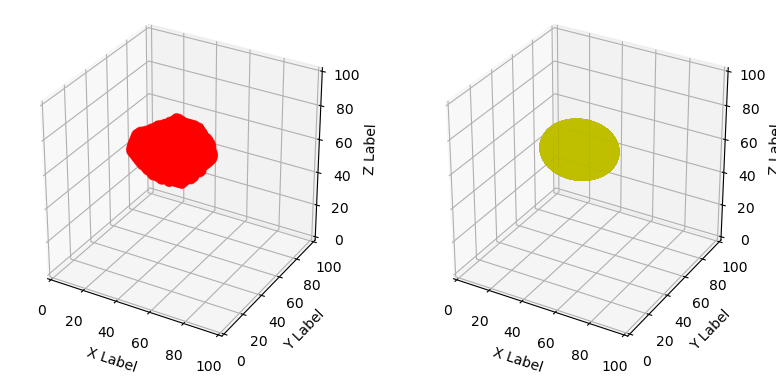

In [9]:
fig = plt.figure(figsize=plt.figaspect(0.5))

# Visualize our grain
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(np.transpose(vertices[A])[0],np.transpose(vertices[A])[1],np.transpose(vertices[A])[2],color='r')
ax.set_xlim([0,100])
ax.set_ylim([0,100])
ax.set_zlim([0,100])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_box_aspect([1.0, 1.0, 1.0])

# Visualize the fitted ellipsoid
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(np.transpose(ellipsoid)[0],np.transpose(ellipsoid)[1],np.transpose(ellipsoid)[2],color='y',alpha=0.1)
ax.set_xlim([0,100])
ax.set_ylim([0,100])
ax.set_zlim([0,100])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_box_aspect([1.0, 1.0, 1.0])

We are also interested in the grain size and shape distribution of our generated RVE. For this purpose, we will calculate for each grain a fitted ellipsoid, and from the ellipsoid the equivalent diameter and grain aspect ratio can be calculated as:

\begin{equation}
d_{RVE} = 2\left( \prod_{i=1}^{3} l_i \right)^{\frac{1}{3}}
\end{equation}
\begin{equation}
a_{RVE} = \frac{\min(l_i)}{\max(l_i)}
\end{equation}

The code below implement these calculations.

In [10]:
d = []
a = []
for i in RVE:
    mu_x, mu_y, mu_z, Sigma, L, R = fitEllipsoid(i)
    # Calculate equivalent diameter, scaled with the resolution
    d.append(np.cbrt(np.prod(L)) * 2 * res)
    # Calculate grain aspect ratio
    a.append(min(L)/max(L))

Finally, we can plot the characteristic distribution of the grains inside our RVE. The experimental distribution of our RVE is given as reference.

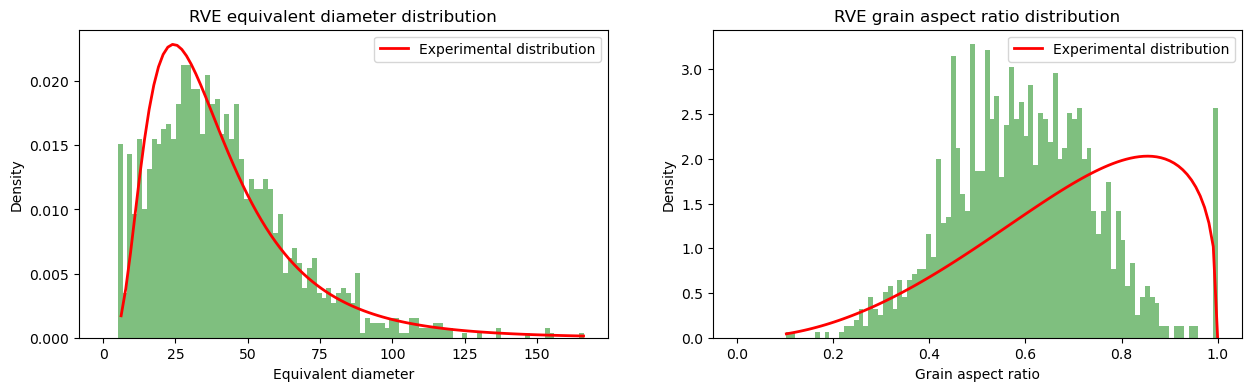

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

# Plot the RVE equivalent diameter distribution
axes[0].hist(d, color='g', bins=np.linspace(0, max(d), 100), alpha=0.5, density=True)
axes[0].plot(np.linspace(min(d), max(d), 100), lognorm.pdf(np.linspace(min(d), max(d), 100), 0.5996, scale=np.exp(3.5503)), 
             'r-', lw=2, label='Experimental distribution')
axes[0].set_xlabel("Equivalent diameter")
axes[0].set_ylabel("Density")
axes[0].set_title("RVE equivalent diameter distribution")
axes[0].legend()

# Plot the RVE grain aspect ratio distribution
axes[1].hist(a, color='g', bins=np.linspace(0, 1, 100), alpha=0.5, density=True)
axes[1].plot(np.linspace(min(a), max(a), 100), beta.pdf(np.linspace(min(a), max(a), 100), 3.1206, 1.3618), 
             'r-', lw=2, label='Experimental distribution')
axes[1].set_xlabel("Grain aspect ratio")
axes[1].set_ylabel("Density")
axes[1].set_title("RVE grain aspect ratio distribution")
axes[1].legend()

To evaluate our results, i.e. how accurately our RVE characterises the material, we will fit our experimental data into the corresponding distribution using the *Maximum Likelihood Estimator* (MLE) and get the parameter. The plot below shows the log-normal distribution of our RVE grain size compared to the experimentally fitted data.

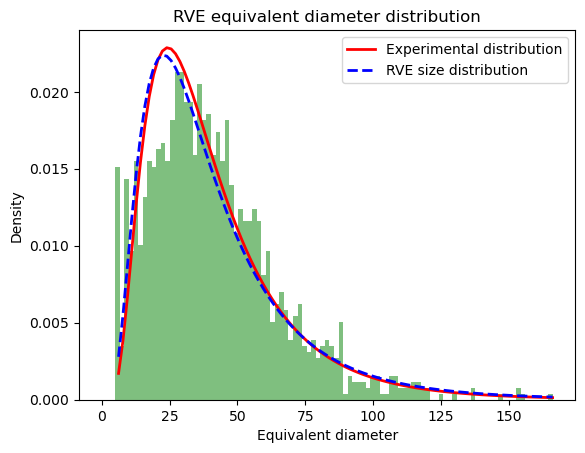

In [12]:
# Find the PDF of our RVE size using MLE
shape, loc, scale = lognorm.fit(d, floc=0)
mu_fit, sigma_fit = np.log(scale), shape

# Plot the RVE equivalent diameter distribution
plt.hist(d, color='g', bins=np.linspace(0, max(d), 100), alpha=0.5, density=True)
plt.plot(np.linspace(min(d), max(d), 100), lognorm.pdf(np.linspace(min(d), max(d), 100), 0.5996, scale=np.exp(3.5503)), 
             'r-', lw=2, label='Experimental distribution')
plt.plot(np.linspace(min(d), max(d), 100), lognorm.pdf(np.linspace(min(d), max(d), 100), sigma_fit, scale=np.exp(mu_fit)), 
             'b--', lw=2, label='RVE size distribution')
plt.xlabel("Equivalent diameter")
plt.ylabel("Density")
plt.title("RVE equivalent diameter distribution")
plt.legend()

Now, the difference between two distributions can be quantitated using the **Hellinger distance**, which quantify the similarity between two probability distributions $P$ and $Q$. The value ranges from $0$ (being the same distribution) to $1$ ($P$ assigns probability zero to every set to which $Q$ assigns a positive probability, and vice versa). In this specific case of log-normal distribution with $P(\mu_1,\sigma_1)$ and $Q(\mu_2,\sigma_2)$, the Hellinger distance is defined as:

\begin{equation}
H(P, Q) = \left[ 1 - \sqrt{\frac{2\sigma_1\sigma_2}{\sigma_1^2+\sigma_2^2}} \,  e^{-\frac{1}{4}\frac{(\mu_1-\mu_2)^2}{\sigma_1^2+\sigma_2^2}} \right]^{\frac{1}{2}}
\end{equation}

In [13]:
# Calculate the Hellinger distance
hellinger_size = np.sqrt(1 - np.sqrt(2*sigma_fit*0.5996/(sigma_fit**2 + 0.5996**2))
                         *np.exp(-1/4 * (mu_fit - 3.5503)**2/(sigma_fit**2 + 0.5996**2)))
# Print the results
print(f"The Hellinger distance of the RVE and experimental size distribution is {hellinger_size}.")

The Hellinger distance of the RVE and experimental size distribution is 0.032235357561045744.


For now, the problem is that I can't seem to fit the beta distribution into the data properly (in other words, the parameters look insane).

In [14]:
# Find the PDF of our RVE size using MLE
ap, be, loc, scale = beta.fit(a, floc=0)
print(f"The parameters of the RVE beta shape distribution is ({ap}, {be}).")

The parameters of the RVE beta shape distribution is (14.487545335525471, 3015393.3186525526).


/opt/software/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
